# Hight-Dimmensional Metrics in Julia

# Introduction

# How to Get Started

In [1]:
# install.packages("hdm")

# Prediction Using Approximate Sparsity

In [2]:
library(hdm)
# 3.2 A Joint Significance test for Lasso Regression
set.seed(1235)
n = 100
#sample size
p = 50
# number of variables
s = 3
# nubmer of variables with non-zero coefficients
X = matrix(rnorm(n * p), ncol = p)
beta = c(rep(5, s), rep(0, p - s))
Y = X %*% beta + rnorm(n) 

# cbind(Y, X)

r_data = function (name = "nn", ...){
    nn = paste0("r_", name, ".csv")
    # cbind(...)
    dta = cbind(...)
    write.csv(dta, nn, row.names = F)
    # print(head(dta))
}

# r_data()
r_data(name = "1", Y, X)
head(Y)

8.7974383
1.0688589
6.1139907
-0.2032082
1.0882188
20.8121398


In [3]:
lasso.reg = rlasso(Y ~ X, post = FALSE)
# use lasso, not-Post-lasso
# lasso.reg = rlasso(X, Y, post=FALSE)
sum.lasso <- summary(lasso.reg, all = FALSE)
# can also do print(lasso.reg, all=FALSE)


Call:
rlasso.formula(formula = Y ~ X, post = FALSE)

Post-Lasso Estimation:  FALSE 

Total number of variables: 50
Number of selected variables: 8 

Residuals: 
    Min      1Q  Median      3Q     Max 
-2.9036 -0.7971  0.1192  0.6712  2.8503 

            Estimate
(Intercept)    0.015
1              4.809
2              4.825
3              4.840
13            -0.002
21            -0.266
28            -0.053
29             0.011
37            -0.022

Residual standard error: 1.068
Multiple R-squared:  0.986
Adjusted R-squared:  0.9847
Joint significance test:
 the sup score statistic for joint significance test is 57.69 with a p-value of     0


In [4]:
set.seed(9)
yhat.lasso = predict(lasso.reg)
#in-sample prediction
Xnew = matrix(rnorm(n * p), ncol = p)
# new X
Ynew = Xnew %*% beta + rnorm(n)
#new Y
yhat.lasso.new = predict(lasso.reg, newdata = Xnew)
#out-of-sample prediction
post.lasso.reg = rlasso(Y ~ X, post = TRUE)
#now use post-lasso
r_data("1.1", Ynew, Xnew)
print(post.lasso.reg, all = FALSE)


Call:
rlasso.formula(formula = Y ~ X, post = TRUE)

(Intercept)            1            2            3           21  
   0.002234     4.981728     5.014848     5.025642    -0.443961  



In [5]:
yhat.postlasso = predict(post.lasso.reg)
#in-sample prediction
yhat.postlasso.new = predict(post.lasso.reg, newdata = Xnew)
#out-of-sample prediction
MAE <- apply(cbind(abs(Ynew - yhat.lasso.new), abs(Ynew - yhat.postlasso.new)), 2,
mean)
names(MAE) <- c("lasso MAE", "Post-lasso MAE")
print(MAE, digits = 2)

     lasso MAE Post-lasso MAE 
           1.1            1.0 


# Inference on Target Regression Coefficients

In [6]:
#4.1 Intuition for the Orthogonality Principle in Linear Models via Partialling Out
set.seed(1)
n = 5000
p = 20
X = matrix(rnorm(n * p), ncol = p)
colnames(X) = c("d", paste("x", 1:19, sep = ""))
xnames = colnames(X)[-1]
beta = rep(1, 20)
y = X %*% beta + rnorm(n)
dat = data.frame(y = y, X)
r_data("2", dat)
# dat

In [7]:
fmla = as.formula(paste("y ~ ", paste(colnames(X), collapse = "+")))
full.fit = lm(fmla, data = dat)
summary(full.fit)$coef["d", 1:2]

Estimate Std. Error 
0.97807455 0.01371225

In [8]:
fmla.y = as.formula(paste("y ~ ", paste(xnames, collapse = "+")))
fmla.d = as.formula(paste("d ~ ", paste(xnames, collapse = "+")))
rY = lm(fmla.y, data = dat)$res
# summary(rY)
# rY
rD = lm(fmla.d, data = dat)$res
partial.fit.ls = lm(rY ~ rD)
summary(partial.fit.ls)$coef["rD", 1:2]

Estimate Std. Error 
0.97807455 0.01368616

In [9]:
rY = rlasso(fmla.y, data = dat)$res
rD = rlasso(fmla.d, data = dat)$res
partial.fit.postlasso = lm(rY ~ rD)
summary(partial.fit.postlasso)$coef["rD", 1:2]

Estimate Std. Error 
0.97273870 0.01368677

# Instrumental Variable Esimation in a High-Dimensional Setting

In [10]:
Eff = rlassoEffect(X[, -1], y, X[, 1], method = "partialling out")
summary(Eff)$coef[, 1:2]

Estimate. Std. Error 
0.97273870 0.01368677

In [11]:
Eff = rlassoEffect(X[, -1], y, X[, 1], method = "double selection")
summary(Eff)$coef[, 1:2]

Estimate. Std. Error 
0.97807455 0.01415624

In [12]:
#4.2 Inference confidence Intervals and Significance Testing
set.seed(1)
n = 100
#sample size
p = 100
# number of variables
s = 3
# nubmer of non-zero variables
X = matrix(rnorm(n * p), ncol = p)
colnames(X) <- paste("X", 1:p, sep = "")
beta = c(rep(3, s), rep(0, p - s))
y = 1 + X %*% beta + rnorm(n)
data = data.frame(cbind(y, X))
colnames(data)[1] <- "y"
fm = paste("y ~", paste(colnames(X), collapse = "+"))
fm = as.formula(fm)

r_data(name = "3", data)


In [13]:
lasso.effect = rlassoEffects(fm, I = ~X1 + X2 + X3 + X8, data = data)
print(lasso.effect)


Call:
rlassoEffects.formula(formula = fm, data = data, I = ~X1 + X2 + 
    X3 + X8)

Coefficients:
     X1       X2       X3       X8  
2.94448  3.04127  2.97540  0.03693  



In [14]:
summary(lasso.effect)

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)    
X1   2.94448    0.08815  33.404   <2e-16 ***
X2   3.04127    0.08389  36.253   <2e-16 ***
X3   2.97540    0.07804  38.127   <2e-16 ***
X8   0.03693    0.07192   0.513    0.608    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [15]:
confint(lasso.effect)

,2.5 %,97.5 %
X1,2.7717131,3.1172421
X2,2.8768512,3.2056979
X3,2.8224496,3.1283583
X8,-0.1040258,0.1778843


In [16]:
confint(lasso.effect, level = 0.99)

,0.5 %,99.5 %
X1,2.7174265,3.1715287
X2,2.8251856,3.2573635
X3,2.7743879,3.1764200
X8,-0.1483171,0.2221756


Warning message:
"Ignoring unknown aesthetics: width, h"


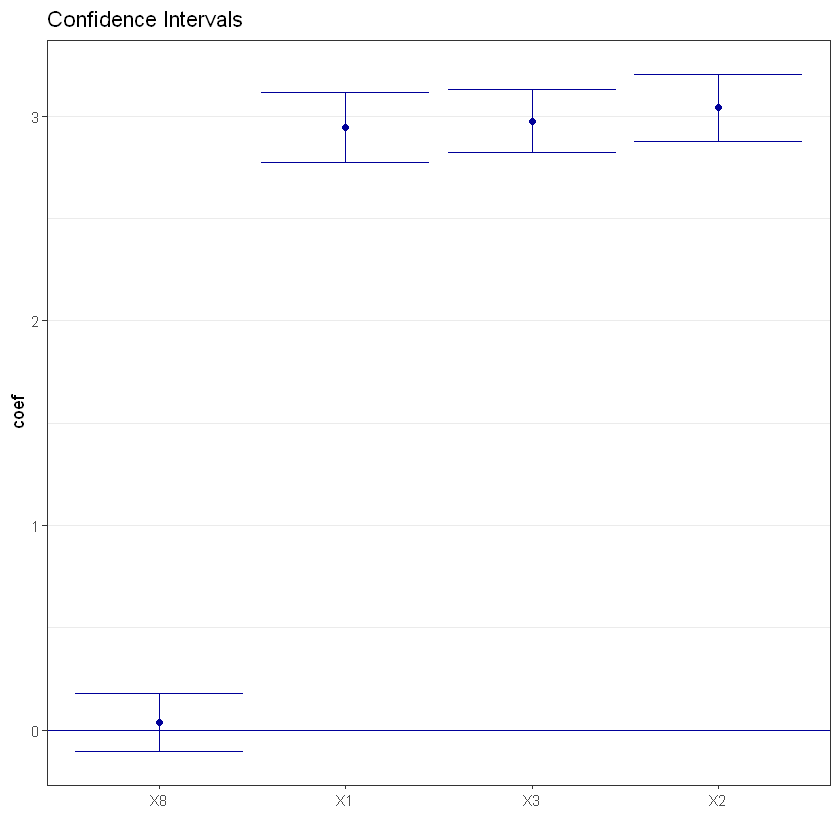

In [17]:
plot(lasso.effect, main = "Confidence Intervals")

In [18]:
cps2012$cps2012

NULL

In [19]:
# # 4.3

library(hdm)
cps2012 = head(hdm::cps2012, 200)
# cps2012 = data(cps2012)
X <- model.matrix(~-1 + widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3, data = cps2012)
# dim(X)
# [1] 29217
# 136
# X <- X[, which(apply(X, 2, var) != 0)]
# exclude all constant variables
# dim(X)
# [1] 29217
# 116
index.gender <- grep("female", colnames(X))
y <- cps2012$lnw
index.gender

integer(0)

In [20]:
# X[, 13:15]

In [21]:
# Sys.sleep(10)
effects.female <- rlassoEffects(x = X[, 13:15], y = y)#index.gender)
summary(effects.female)

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)
exp1   0.02949    0.02204   1.338    0.181
exp2  -0.09115    0.36770  -0.248    0.804
exp3  -0.02748    0.02227  -1.234    0.217



In [22]:
joint.CI <- confint(effects.female, level = 0.95)#, joint = TRUE)
joint.CI

,2.5 %,97.5 %
exp1,-0.01371119,0.07268410
exp2,-0.81183008,0.62953799
exp3,-0.07113002,0.01617279


In [23]:
# Sys.sleep(7)
effects.female <- rlassoEffects(lnw ~ female + female:(widowed + divorced + separated +
nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 +
exp3) + (widowed + divorced + separated + nevermarried + hsd08 + hsd911 + hsg +
cg + ad + mw + so + we + exp1 + exp2 + exp3)^2, data = cps2012, I = ~female +
female:(widowed + divorced + separated + nevermarried + hsd08 + hsd911 + hsg +
cg + ad + mw + so + we + exp1 + exp2 + exp3))

ERROR: Error in lasso.regs[[i]] <- try(col <- rlassoEffect(Xt, y, d, method = method, : attempt to select less than one element in integerOneIndex


In [24]:
# 4.4

GrowthData = head(hdm::GrowthData, 200)
# data(GrowthData)
# dim(GrowthData)
# [1] 90 63
y = GrowthData[, 1, drop = F]
d = GrowthData[, 3, drop = F]
X = as.matrix(GrowthData)[, -c(1, 2, 3)]
X1 = as.matrix(GrowthData)[, -c(1, 2)]
varnames = colnames(GrowthData)

In [ ]:
xnames = varnames[-c(1, 2, 3)]
# names of X variables
dandxnames = varnames[-c(1, 2)]
# names of D and X variables
# create formulas by pasting names (this saves typing times)
fmla = as.formula(paste("Outcome ~ ", paste(dandxnames, collapse = "+")))
ls.effect = lm(fmla, data = GrowthData)
ls.effect = lm(as.matrix(y) ~ X1[, 1:42])
ls.effect
# ls.effect
# lm(y ~ X1)
# y
# solve(t(X1) %*% X1) %*% (t(X1) %*% Y)

In [99]:
dim(X)

[1] 90 60

In [31]:
dX = as.matrix(cbind(d, X))
lasso.effect = rlassoEffect(x = X, y = y, d = d, method = "partialling out")
summary(lasso.effect)

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
[1,]  -0.04981    0.01394  -3.574 0.000351 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [32]:
dX = as.matrix(cbind(d, X))
doublesel.effect = rlassoEffect(x = X, y = y, d = d, method = "double selection")
summary(doublesel.effect)

[1] "Estimates and significance testing of the effect of target variables"
         Estimate. Std. Error t value Pr(>|t|)   
gdpsh465  -0.05001    0.01579  -3.167  0.00154 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [30]:
library(xtable)
table = rbind(summary(ls.effect)$coef["gdpsh465", 1:2], summary(lasso.effect)$coef[,
1:2], summary(doublesel.effect)$coef[, 1:2])
colnames(table) = c("Estimate", "Std. Error")
#names(summary(full.fit)£coef)[1:2]
rownames(table) = c("full reg via ols", "partial reg
via post-lasso ", "partial reg via double selection")
tab = xtable(table, digits = c(2, 2, 5))
tab

,Estimate,Std. Error
,<dbl>,<dbl>
full reg via ols,-0.009377989,0.02988773
partial reg via post-lasso,-0.049811465,0.01393636
partial reg via double selection,-0.050005855,0.01579138


# Inference on Treatment Effects in a Hight-Dimensional Setting

In [33]:
#5.1
AJR = head(hdm::AJR, 200)
y = AJR$GDP
d = AJR$Exprop
z = AJR$logMort
x = model.matrix(~-1 + Latitude + Latitude2 + Africa + Asia + Namer + Samer,
data = AJR)
# dim(AJR)

In [32]:
AJR.Xselect = rlassoIV(GDP ~ Exprop + (Latitude + Latitude2 + Africa + Asia + Namer +
Samer)^2 | logMort + (Latitude + Latitude2 + Africa + Asia + Namer + Samer)^2,
data = AJR, select.X = TRUE, select.Z = FALSE)
summary(AJR.Xselect)

[1] "Estimation and significance testing of the effect of target variables in the IV regression model"
       coeff.    se. t-value p-value   
Exprop 0.8450 0.2699   3.131 0.00174 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [33]:
confint(AJR.Xselect)

           2.5 %   97.5 %
Exprop 0.3159812 1.374072


In [35]:
fmla.y = GDP ~ Latitude + Latitude2 + Africa + Asia + Namer + Samer
fmla.d = Exprop ~ (Latitude + Latitude2 + Africa + Asia + Namer + Samer)
fmla.z = logMort ~ (Latitude + Latitude2 + Africa + Asia + Namer + Samer)
rY = lm(fmla.y, data = AJR)$res
rD = lm(fmla.d, data = AJR)$res
rZ = lm(fmla.z, data = AJR)$res
# ivfit.lm = tsls(y=rY,d=rD, x=NULL, z=rZ, intercept=FALSE)
ivfit.lm = tsls(rY ~ rD | rZ, intercept = FALSE)
ivfit.lm
# print(cbind(ivfit.lm$coef, ivfit.lm$se), digits = 3)


Call:
tsls.formula(formula = rY ~ rD | rZ, intercept = FALSE)

Coefficients:
    Estimate
rD  1.088   


In [36]:
rY = rlasso(fmla.y, data = AJR)$res
rD = rlasso(fmla.d, data = AJR)$res
rZ = rlasso(fmla.z, data = AJR)$res
ivfit.lasso = tsls(y=rY,d=rD, x=NULL, z=rZ, intercept=FALSE)
# ivfit.lasso = tsls(rY ~ rD | rZ, intercept = FALSE)
ivfit.lasso
# print(cbind(ivfit.lasso$coef, ivfit.lasso$se), digits = 3)


Call:
tsls.default(x = NULL, d = rD, y = rY, z = rZ, intercept = FALSE)

Coefficients:
    Estimate
d1  0.7978  


In [36]:
EminentDomain = head(hdm::EminentDomain, 200)
z <- as.matrix(EminentDomain$logGDP$z)
x <- as.matrix(EminentDomain$logGDP$x)
y <- EminentDomain$logGDP$y
d <- EminentDomain$logGDP$d
x <- x[, apply(x, 2, mean, na.rm = TRUE) > 0.05]
#
z <- z[, apply(z, 2, mean, na.rm = TRUE) > 0.05]
#

In [37]:
ED.ols = lm(y ~ cbind(d, x))
ED.2sls = tsls(y = y, d = d, x = x, z = z[, 1:2], intercept = FALSE)

In [38]:
lasso.IV.Z = rlassoIV(x = x, d = d, y = y, z = z, select.X = FALSE, select.Z = TRUE)
# or lasso.IV.Z = rlassoIVselectZt(x=X, d=d, y=y, z=z)
summary(lasso.IV.Z)

[1] "Estimates and significance testing of the effect of target variables in the IV regression model"
   coeff.    se. t-value p-value
d1 0.4146 0.2902   1.428   0.153




In [39]:
confint(lasso.IV.Z)

        2.5 %    97.5 %
d1 -0.1542764 0.9834796


In [40]:
lasso.IV.XZ = rlassoIV(x = x, d = d, y = y, z = z, select.X = TRUE, select.Z = TRUE)
summary(lasso.IV.XZ)

Estimates and Significance Testing of the effect of target variables in the IV regression model 
     coeff.      se. t-value p-value
d1 -0.02383  0.12851  -0.185   0.853




In [41]:
confint(lasso.IV.XZ)

        2.5 %    97.5 %
d1 -0.2757029 0.2280335


In [42]:
library(xtable)
table = matrix(0, 4, 2)
table[1, ] = summary(ED.ols)$coef[2, 1:2]
table[2, ] = cbind(ED.2sls$coef[1], ED.2sls$se[1])
table[3, ] = summary(lasso.IV.Z)[, 1:2]

[1] "Estimates and significance testing of the effect of target variables in the IV regression model"
   coeff.    se. t-value p-value
d1 0.4146 0.2902   1.428   0.153




In [43]:
table[4, ] = summary(lasso.IV.XZ)[, 1:2]

Estimates and Significance Testing of the effect of target variables in the IV regression model 
     coeff.      se. t-value p-value
d1 -0.02383  0.12851  -0.185   0.853




In [44]:
colnames(table) = c("Estimate", "Std. Error")
rownames(table) = c("ols regression", "IV estimation ", "selection on Z", "selection on X and Z")
tab = xtable(table, digits = c(2, 2, 7))
tab

,Estimate,Std. Error
,<dbl>,<dbl>
ols regression,0.007864732,0.009865927
IV estimation,-0.010733269,0.033766362
selection on Z,0.414601641,0.290249208
selection on X and Z,-0.023834697,0.128506538


In [45]:
pension = head(hdm::pension, 200)
y = pension$tw
d = pension$p401
z = pension$e401
X = pension[, c("i2", "i3", "i4", "i5", "i6", "i7", "a2", "a3", "a4", "a5", "fsize",
"hs", "smcol", "col", "marr", "twoearn", "db", "pira", "hown")]
# simple model
xvar = c("i2", "i3", "i4", "i5", "i6", "i7", "a2", "a3", "a4", "a5", "fsize", "hs",
"smcol", "col", "marr", "twoearn", "db", "pira", "hown")
xpart = paste(xvar, collapse = "+")
form = as.formula(paste("tw ~ ", paste(c("p401", xvar), collapse = "+"), "|", paste(xvar,
collapse = "+")))
formZ = as.formula(paste("tw ~ ", paste(c("p401", xvar), collapse = "+"), "|", paste(c("e401",
xvar), collapse = "+")))

In [46]:
pension.ate = rlassoATE(form, data = pension)
summary(pension.ate)

ERROR: Error in check_binary(d): Treatment variable and Instrumental Variable should be binary (0/1)!


In [ ]:
pension.atet = rlassoATET(form, data = pension)
summary(pension.atet)

Estimation and significance testing of the treatment effect 
Type: ATET 
Bootstrap: not applicable 
   coeff.   se. t-value p-value    
TE  12628  2944   4.289 1.8e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




## Error

In [ ]:
# pension.late = rlassoLATE(X, d, y, z)
# pension.late = rlassoLATE(formZ, data=pension)
# summary(pension.late)

In [ ]:
# pension.latet = rlassoLATET(X, d, y, z)

In [ ]:
xvar2 <- paste("(", xvar, ")^2", sep = "")
formExt = as.formula(paste("tw ~ ", paste(c("p401", xvar2), collapse = "+"), "|",
paste(xvar2, collapse = "+")))
formZExt = as.formula(paste("tw ~ ", paste(c("p401", xvar2), collapse = "+"), "|",
paste(c("e401", xvar2), collapse = "+")))

In [ ]:
pension.ate = rlassoATE(X, z, y)
pension.atet = rlassoATET(X, z, y)
# pension.late = rlassoLATE(X, d, y, z)
# pension.latet = rlassoLATET(X, d, y, z)

# The Lasso Methods for Discovery of Significant Causes amongst Many Potential Causes, with Many Controls

In [ ]:
set.seed(1)
n = 100
p1 = 20
p2 = 20
D = matrix(rnorm(n * p1), n, p1)
# Causes
W = matrix(rnorm(n * p2), n, p2)
X = cbind(D, W)
# Regressors
Y = D[, 1] * 5 + W[, 1] * 5 + rnorm(n)
#Outcome
confint(rlassoEffects(X, Y, index = c(1:p1)), joint = TRUE)

,2.5 %,97.5 %
V1,4.5145877,5.21430498
V2,-0.3142909,0.30494650
V3,-0.3524109,0.18678880
V4,-0.2542430,0.28738914
V5,-0.2765802,0.27627177
V6,-0.3214676,0.29422684
V7,-0.2262507,0.30094168
V8,-0.0473541,0.47366372
V9,-0.1865636,0.39023520
V10,-0.2372356,0.26411185
